<a href="https://colab.research.google.com/github/Taiba528/My-Python-World/blob/master/Ham_SpamCLassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Here I am going to analyse the tweets whether its ham & spam.I am going to explore the data first with different tools (word frequency, and word cloud)

In [1]:
#import necessary packages for analysis
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import collections
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score, recall_score
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
# load dataset
from google.colab import files
uploaded = files.upload()

Saving SMS-Messages2.csv to SMS-Messages2 (2).csv


In [4]:
#read file
df = pd.read_csv("SMS-Messages2.csv")
df.head()

,Message,Class_Label
0,'Go until jurong point,ham
1,'Ok lar... Joking wif u oni...',ham
2,'Free entry in 2 a wkly comp to win FA Cup fin...,spam
3,'U dun say so early hor... U c already then sa...,ham
4,'Nah I don\'t think he goes to usf,ham


# Data understanding :Explore the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0    Message     200 non-null    object
 1   Class_Label  200 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


data set contains only two Columns  with messages & labels assigned with it without any missing value.

#Plot the data for visualization

In [6]:
df.groupby(['Class_Label']).count()

,Message
Class_Label,
ham,167
spam,33


Text(0.5, 0, 'Label')

Text(0.5, 1.0, 'Number of ham and spam messages')

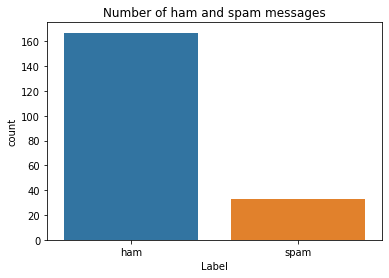

In [7]:
#Visualize the number of ham and spam messages
sns.countplot(df['Class_Label'])
plt.xlabel('Label')
plt.title('Number of ham and spam messages')



In [0]:
plot_size = plt.rcParams["figure.figsize"] 
plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

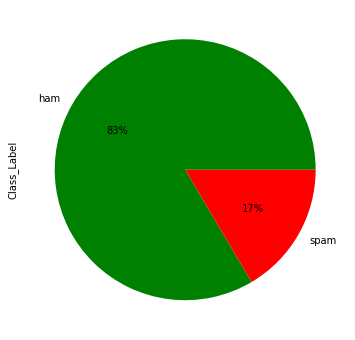

In [9]:
df.Class_Label.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["green","red"])

### out of 200 messages 167 which is 83% in total are ham messages while 17% are spam .

In [10]:
df=df.rename(columns={' Message':'Message','Class_Label':'label'})
df.columns

Index(['Message', 'label'], dtype='object')

### From  bar graph &Pie-chart I understand that only 17% tweets spam,while 83% are ham.


Text(0.5, 1.0, 'ham_messages')

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'spam_messages')

(-0.5, 399.5, 199.5, -0.5)

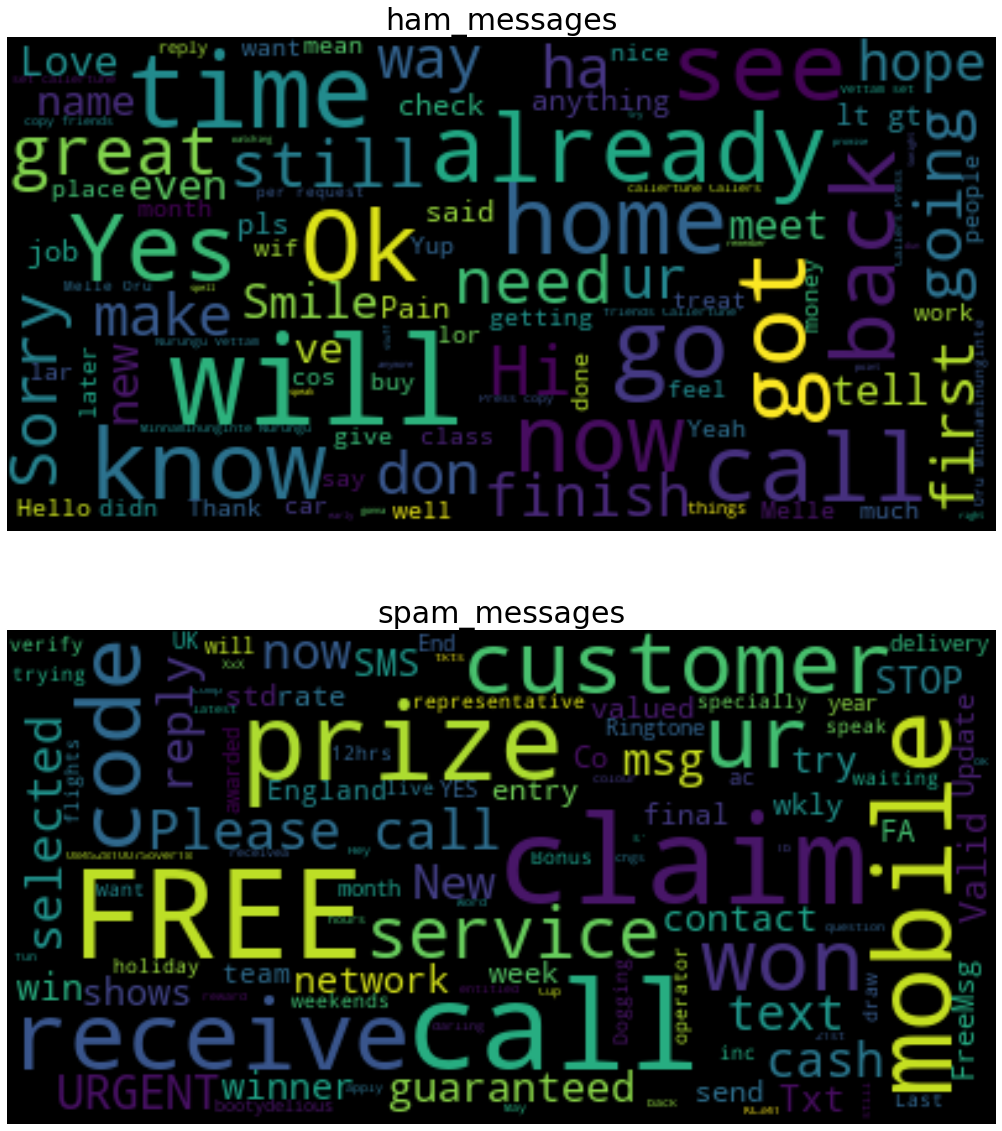

In [11]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
# Start with one message:
df_ham=df[df['label'] == 'ham']
df_spam=df[df['label']=='spam']

message_all=" ".join(message for message in df.Message)
message_ham=" ".join(message for message in df_ham.Message)
message_spam=" ".join(message for message in df_spam.Message)


# Create and generate a word cloud image:
fig, ax = plt.subplots(2, 1, figsize  = (20,20))
wordcloud_ham = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(message_ham)
wordcloud_spam = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(message_spam)

# Display the generated image:
ax[0].imshow(wordcloud_ham, interpolation='bilinear')
ax[0].set_title('ham_messages', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_spam, interpolation='bilinear')
ax[1].set_title('spam_messages',fontsize=30)
ax[1].axis('off')

From word cloud it can be visualize easily that while ham messages contains simple conversation words like 'love','sorry','already','yes'.'ok'etc,spam messages mostly contains some exciting words like 'prizes','selected','won','claim'etc which requires receiver's attention immediately.

## Tokenization


In [12]:
word_list = []

max = len(df.Message)
for i in range (max):
  R1= df.Message[i]
  tokens = R1.split()
  #print(tokens)
  words = []
  
  for token in tokens:
    words.append(token.lower())
  word_list.append(words) 
print(len(word_list))
word_list[0:5]

200


[["'go", 'until', 'jurong', 'point'],
 ["'ok", 'lar...', 'joking', 'wif', 'u', "oni...'"],
 ["'free",
  'entry',
  'in',
  '2',
  'a',
  'wkly',
  'comp',
  'to',
  'win',
  'fa',
  'cup',
  'final',
  'tkts',
  '21st',
  'may',
  '2005.',
  'text',
  'fa',
  'to',
  '87121',
  'to',
  'receive',
  'entry',
  'question(std',
  'txt',
  "rate)t&c\\'s",
  'apply',
  "08452810075over18\\'s'"],
 ["'u",
  'dun',
  'say',
  'so',
  'early',
  'hor...',
  'u',
  'c',
  'already',
  'then',
  "say...'"],
 ["'nah", 'i', "don\\'t", 'think', 'he', 'goes', 'to', 'usf']]

# Lexicon approach

In [13]:
#Load the Lexicon file
from google.colab import files
uploaded=files.upload()

Saving AFINN-111.csv to AFINN-111 (3).csv


In [0]:
#Read the Lexicon File
lex_file = open("AFINN-111.csv",encoding='cp1252')

In [0]:
lexicons = {}
records = lex_file.readlines()
for record in records:
    print(record) # line contains newline charecter
    print(record.rstrip('\n').split(",")) #to remove new line charecter
    lexicons[record.rstrip('\n').split(",")[0]] = int(record.rstrip('\n').split(",")[1])


In [23]:
#For each word in text
#Get the word score (score is a number if the word is in Lexicon, 0 if not)
#Add all the scores and find the ploarity
strength = []
for text in word_list:
    score = 0
    for word in text:
        if word in (lexicons):
            score = int(score + lexicons[word])
    strength.append(score)
strength[5]

0

In [24]:
df['strength'] = strength
df.tail()

,Message,label,strength
195,'How are you doing? Hope you\'ve settled in fo...,ham,0
196,'Gud mrng dear hav a nice day',ham,0
197,'Did u got that persons story',ham,0
198,'is your hamster dead? Hey so tmr i meet you a...,ham,0
199,'Hi its Kate how is your evening? I hope i can...,ham,0


# Feature Engineering

### Now I will do feature engineering and use BAG OF WORDS Technique to work with Naive bayes model

In [28]:
df_ham['length']=df['Message'].apply(len)
df_ham.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Message,label,length
0,'Go until jurong point,ham,22
1,'Ok lar... Joking wif u oni...',ham,31
3,'U dun say so early hor... U c already then sa...,ham,51
4,'Nah I don\'t think he goes to usf,ham,34
6,'Even my brother is not like to speak with me....,ham,79


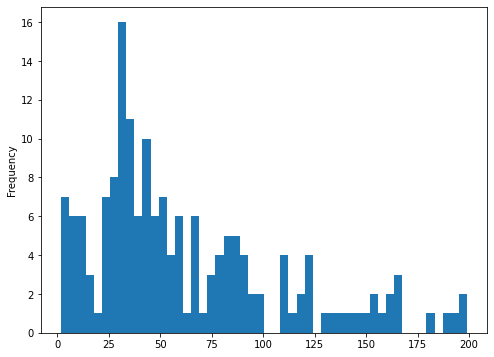

In [29]:
df_ham['length'].plot.hist(bins=50)

In [30]:
df_spam['length']=df['Message'].apply(len)
df_spam.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Message,label,length
2,'Free entry in 2 a wkly comp to win FA Cup fin...,spam,159
5,'FreeMsg Hey there darling it\'s been 3 week\'...,spam,137
8,'WINNER!! As a valued network customer you hav...,spam,159
9,'Had your mobile 11 months or more? U R entitl...,spam,156
11,'SIX chances to win CASH! From 100 to 20,spam,40


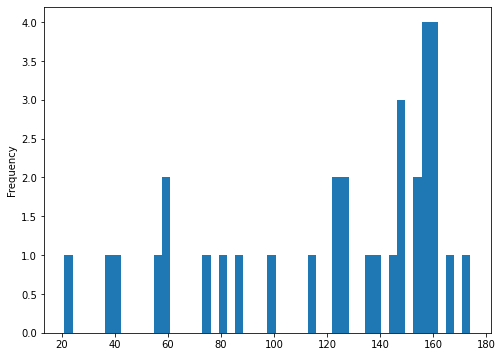

In [31]:
df_spam['length'].plot.hist(bins=50)

### It can be obsereved that SPAM messages generally have more characters

##Creating Labels and Features to apply ML models

In [32]:
#creating label & features
x = df.iloc[:, 0]
x.head()
y = df.iloc[:, 1]
y.head()


0                               'Go until jurong point
1                      'Ok lar... Joking wif u oni...'
2    'Free entry in 2 a wkly comp to win FA Cup fin...
3    'U dun say so early hor... U c already then sa...
4                   'Nah I don\'t think he goes to usf
Name: Message, dtype: object

0     ham
1     ham
2    spam
3     ham
4     ham
Name: label, dtype: object

# Data preprocessing

In [34]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   200 non-null    object
 1   label     200 non-null    object
 2   strength  200 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


#Tokenization & Cleaning data

In [40]:
nopunc=[c for c in df['Message'] if c not in string.punctuation]
nopunc=''.join(nopunc)
nopunc.split()
clean_message=[word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


["'Go",
 'until',
 'jurong',
 "point'Ok",
 'lar...',
 'Joking',
 'wif',
 'u',
 "oni...''Free",
 'entry',
 'in',
 '2',
 'a',
 'wkly',
 'comp',
 'to',
 'win',
 'FA',
 'Cup',
 'final',
 'tkts',
 '21st',
 'May',
 '2005.',
 'Text',
 'FA',
 'to',
 '87121',
 'to',
 'receive',
 'entry',
 'question(std',
 'txt',
 "rate)T&C\\'s",
 'apply',
 "08452810075over18\\'s''U",
 'dun',
 'say',
 'so',
 'early',
 'hor...',
 'U',
 'c',
 'already',
 'then',
 "say...''Nah",
 'I',
 "don\\'t",
 'think',
 'he',
 'goes',
 'to',
 "usf'FreeMsg",
 'Hey',
 'there',
 'darling',
 "it\\'s",
 'been',
 '3',
 "week\\'s",
 'now',
 'and',
 'no',
 'word',
 'back!',
 "I\\'d",
 'like',
 'some',
 'fun',
 'you',
 'up',
 'for',
 'it',
 'still?',
 'Tb',
 'ok!',
 'XxX',
 'std',
 'chgs',
 'to',
 "send'Even",
 'my',
 'brother',
 'is',
 'not',
 'like',
 'to',
 'speak',
 'with',
 'me.',
 'They',
 'treat',
 'me',
 'like',
 'aids',
 "patent.''As",
 'per',
 'your',
 'request',
 "\\'Melle",
 'Melle',
 '(Oru',
 'Minnaminunginte',
 'Nurungu',


In [42]:
def text_process( Message):
    nopunc=[char for char in  Message if char not in string.punctuation]
    
    nopunc=''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english') ]
df['Message'].head(5).apply(text_process)

0                                  [Go, jurong, point]
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4                        [Nah, dont, think, goes, usf]
Name: Message, dtype: object

In [47]:
#Bag of word model
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer=CountVectorizer(analyzer=text_process).fit(df['Message'])
messages_bow=bow_transformer.transform( df['Message'])
print('Shape of Sparse Matrix: ',messages_bow.shape)


Shape of Sparse Matrix:  (200, 1027)


In [56]:
#TF IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(messages_bow)
df_tfidf=tfidf_transformer.transform(messages_bow)
df_tfidf

<200x1027 sparse matrix of type '<class 'numpy.float64'>'
	with 1565 stored elements in Compressed Sparse Row format>

In [0]:
# Train Test Split

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.35, random_state = 0)

In [0]:
#Naive bayes model
from sklearn.naive_bayes import MultinomialNB
spam_detect_model=MultinomialNB().fit(df_tfidf,df['label'])

In [136]:
#Instead of doing everything again, in which we have to get rid of punctuation, get rid of stop words, 
# And then do tf and idf we would use Pipelines option
from sklearn.pipeline import Pipeline

pipeline=Pipeline([
        ('bow',CountVectorizer(analyzer=text_process)),
        ('tfidf',TfidfTransformer()),
        ('classifier',MultinomialNB())
    ])
pipeline.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f7950a97950>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [0]:
predicted=pipeline.predict(x_test)

In [138]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predicted),confusion_matrix(y_test,predicted))


              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       1.00      0.20      0.33        10

    accuracy                           0.89        70
   macro avg       0.94      0.60      0.64        70
weighted avg       0.90      0.89      0.85        70
 [[60  0]
 [ 8  2]]


###Although accuracy is high here & even f1-score is good for ham(1) messages but for spam(2)messages  recall &f1-score is not so good.So I need to build a better model with some other classification model or may be need to tune the model  a little bit.
###it might be  due to less number of data for spam messages like here only 10 samples for spam messages are avialable in my test data.So it can be corrected with some other sampling technique like undersampling or oversampling technique as well.